In [1]:
import skdim
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import torch
import nltk
from plotly.subplots import make_subplots
from phd import get_phd, get_raw_phd, get_embeds, get_raw_phd_in_loop
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import modeling_utils
if not hasattr(modeling_utils, "ALL_PARALLEL_STYLES") or modeling_utils.ALL_PARALLEL_STYLES is None:
    modeling_utils.ALL_PARALLEL_STYLES = ["tp", "none", "colwise", 'rowwise']

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import jsonlines

# file_path = 'data/subtaskA_train_monolingual.jsonl'
# file_path = 'data/HelloBench/length_constrained_data/heuristic_text_generation_2k.jsonl'
file_path = 'data/en_train.jsonl'

data = []
with jsonlines.open(file_path, 'r') as reader:
    for obj in reader:
        data.append(obj)


In [4]:
import pandas as pd


df = pd.DataFrame(data)

In [5]:
df

,id,source,sub_source,lang,model,label,text
0,f05034ca-d1da-445d-a6a2-5869ade0dfc3,m4gt,reddit,en,llama3-8b,1,Hitler's plans for the succession and power st...
1,e7d7fe23-3709-4e14-aa2d-d76821dcbdf6,mage,squad,en,human,0,The Bush administration then turned its attent...
2,1a68d42e-4202-4e36-bceb-02d693440a14,mage,yelp,en,human,0,Really really the best pedi ever! Pho was so a...
3,5de844ab-c197-4378-b144-c3a46e3f5b67,mage,xsum,en,human,0,The PS42m MV Loch Seaforth made its first pass...
4,cdf050ad-7d90-4235-b7c6-46ca6cfc4382,m4gt,wikipedia,en,human,0,Malta participated in the Eurovision Song Cont...
...,...,...,...,...,...,...,...
610762,86d1f898-370b-4f57-a0ae-79eb435e96ed,m4gt,reddit,en,llama3-8b,1,"Okay, so like, galaxies and supermassive black..."
610763,611dc4e9-9bc7-46c6-8e9c-ee52b7931b4d,m4gt,outfox,en,gpt4o,1,"When individuals face tough decisions, the sta..."
610764,43347c3b-81b3-4f3f-985d-7898b81d2fdb,m4gt,wikipedia,en,human,0,"Ekrem Bora (born 3 September 1983), better kno..."
610765,b9617f97-3a28-450c-bf6b-010529b2a985,mage,roct,en,text-davinci-002,1,Randy was always a prankster. He loved to play...


In [52]:
def get_embeds_and_tokens(df):
    embeds_list = []
    tokens_list = []
    embeds_list_text = []
    tokens_list_text = []
    for i in tqdm(range(2, 50, 2)):
        text = ''.join(df['text'].values.tolist()[i:(i + 1)])
        embeds, tokens = get_embeds(text[:2000], returns_tokenized=True)
        embeds_list.extend(embeds)
        tokens_list.extend(tokens)
        embeds_list_text.append(embeds)
        tokens_list_text.append(tokens)

    return embeds_list, tokens_list, embeds_list_text, tokens_list_text

In [53]:
embeds_list_4o, tokens_list_4o, embeds_list_4o_text, tokens_list_4o_text = get_embeds_and_tokens(df.query("model == 'gpt4o'"))
embeds_list_human, tokens_list_human, embeds_list_human_text, tokens_list_human_text = get_embeds_and_tokens(df.query("model == 'human'"))

100%|███████████████████████████████████████████| 24/24 [00:16<00:00,  1.44it/s]


## Дает PHD по каждому тексту в целом и по частям речи в тексте

In [63]:
def get_phds_by_text(tokens_list, embeds_list):
    """
    Дает PHD по каждому тексту в целом и по частям речи в тексте
    tokens_list - List[List[token]] - список, в котором содержится список токенов.
    embeds_list - List[embeds_for_text] - список из эмбеддингов для каждого токена.
    """
    phds = []
    for embeds_text, tokens in zip(embeds_list, tokens_list):
        tagged_tokens = nltk.pos_tag(tokens, tagset='universal')
        df_token2type = pd.DataFrame(tagged_tokens, columns=['token', 'type_token'])
        df_token2type['embed'] = [embed for embed in embeds_text]
        typetoken2phd = dict()
        for type_token in ['NOUN', '.']:
            df_subsample = df_token2type.query("type_token == @type_token")
            embeds_subsample = np.array(df_subsample['embed'].apply(pd.Series).values)
            print(np.array(embeds_subsample).min())
            phd = get_raw_phd_in_loop((np.array(embeds_subsample) + np.array(embeds_subsample).min()) / (embeds_subsample.max() - embeds_subsample.min()))
            typetoken2phd[type_token] = phd
            all_embeds = np.array(df_token2type['embed'].apply(pd.Series).values)
            all_embeds_normed = (all_embeds + all_embeds.min()) / (all_embeds.max() - all_embeds.min())
            phd_all = get_raw_phd_in_loop(all_embeds_normed)
            phds.append(phd_all)
    return phds, typetoken2phd

## Дает PHD по каждому тексту в целом и phd текста БЕЗ этой части речи в тексте

In [64]:
def get_phds_by_text_without(tokens_list, embeds_list):
    """
    Дает PHD по каждому тексту в целом и по частям речи в тексте
    tokens_list - List[List[token]] - список, в котором содержится список токенов.
    embeds_list - List[embeds_for_text] - список из эмбеддингов для каждого токена.
    """
    phds = []
    for embeds_text, tokens in zip(embeds_list, tokens_list):
        tagged_tokens = nltk.pos_tag(tokens, tagset='universal')
        df_token2type = pd.DataFrame(tagged_tokens, columns=['token', 'type_token'])
        df_token2type['embed'] = [embed for embed in embeds_text]
        typetoken2phd = dict()
        for type_token in ['NOUN', '.']:
            df_subsample = df_token2type.query("type_token != @type_token")
            embeds_subsample = np.array(df_subsample['embed'].apply(pd.Series).values)
            print(np.array(embeds_subsample).min())
            phd = get_raw_phd_in_loop((np.array(embeds_subsample) + np.array(embeds_subsample).min()) / (embeds_subsample.max() - embeds_subsample.min()))
            typetoken2phd[type_token] = phd
            all_embeds = np.array(df_token2type['embed'].apply(pd.Series).values)
            all_embeds_normed = (all_embeds + all_embeds.min()) / (all_embeds.max() - all_embeds.min())
            phd_all = get_raw_phd_in_loop(all_embeds_normed)
            phds.append(phd_all)
    return phds, typetoken2phd

In [45]:
def apply_pos_tag(tokens, embeds):
    """
    tokens - List[token] - список токенов для одного длинного текста, который может представлять собой объединение нескольких независимых текстов
    embeds - List[embed] - список эмбеддингов токенов для одного длинного текста, который может представлять собой объединение нескольких независимых текстов
    """
    tagged_tokens = nltk.pos_tag(tokens, tagset='universal')
    df_token2type = pd.DataFrame(tagged_tokens, columns=['token', 'type_token'])
    df_token2type['embed'] = [embed for embed in embeds]
    typetoken2phd = dict()
    for type_token in ['NOUN', '.', 'VERB', 'ADJ']:
        df_subsample = df_token2type.query("type_token == @type_token")
        embeds_subsample = np.array(df_subsample['embed'].apply(pd.Series).values)
        print(np.array(embeds_subsample).min())
        phd = get_raw_phd_in_loop((np.array(embeds_subsample) + np.array(embeds_subsample).min()) / (embeds_subsample.max() - embeds_subsample.min()))
        typetoken2phd[type_token] = phd

    return typetoken2phd

In [67]:
def apply_pos_tag_without(tokens, embeds):
    """
    tokens - List[token] - список токенов для одного длинного текста, который может представлять собой объединение нескольких независимых текстов
    embeds - List[embed] - список эмбеддингов токенов для одного длинного текста, который может представлять собой объединение нескольких независимых текстов
    """
    tagged_tokens = nltk.pos_tag(tokens, tagset='universal')
    df_token2type = pd.DataFrame(tagged_tokens, columns=['token', 'type_token'])
    df_token2type['embed'] = [embed for embed in embeds]
    typetoken2phd = dict()
    for type_token in ['NOUN', '.', 'VERB', 'ADJ']:
        df_subsample = df_token2type.query("type_token != @type_token")
        embeds_subsample = np.array(df_subsample['embed'].apply(pd.Series).values)
        print(np.array(embeds_subsample).min())
        phd = get_raw_phd_in_loop((np.array(embeds_subsample) + np.array(embeds_subsample).min()) / (embeds_subsample.max() - embeds_subsample.min()))
        typetoken2phd[type_token] = phd

    return typetoken2phd

In [ ]:
# Усреднение по текстам

In [66]:
typetoken2phd_4o = apply_pos_tag(tokens_list_4o, embeds_list_4o)
typetoken2phd_human = apply_pos_tag(tokens_list_human, embeds_list_human)


-12.3963785
mn_points =  40 max_points =  4622 point_jump =  654
input_shape: (4622, 768)
mn_points =  40 max_points =  4622 point_jump =  654
input_shape: (4622, 768)
mn_points =  40 max_points =  4622 point_jump =  654
input_shape: (4622, 768)
mn_points =  40 max_points =  4622 point_jump =  654
input_shape: (4622, 768)
mn_points =  40 max_points =  4622 point_jump =  654
input_shape: (4622, 768)
mn_points =  40 max_points =  4622 point_jump =  654
input_shape: (4622, 768)
mn_points =  40 max_points =  4622 point_jump =  654
input_shape: (4622, 768)
mn_points =  40 max_points =  4622 point_jump =  654
input_shape: (4622, 768)
mn_points =  40 max_points =  4622 point_jump =  654
input_shape: (4622, 768)
mn_points =  40 max_points =  4622 point_jump =  654
input_shape: (4622, 768)
-10.804724
mn_points =  40 max_points =  750 point_jump =  101
input_shape: (750, 768)
mn_points =  40 max_points =  750 point_jump =  101
input_shape: (750, 768)
mn_points =  40 max_points =  750 point_jump 

NameError: name 'apply_pos_tag_without' is not defined

In [68]:
typetoken2phd_4o_without = apply_pos_tag_without(tokens_list_4o, embeds_list_4o)
typetoken2phd_human_without = apply_pos_tag_without(tokens_list_human, embeds_list_human)
phds_by_text_4o, typetoken2phd_by_text_4o = get_phds_by_text(tokens_list_4o, embeds_list_4o)
phds_by_text_human, typetoken2phd_by_text_human = get_phds_by_text(tokens_list_human, embeds_list_human)
phds_by_text_4o_without, typetoken2phd_4o_without = get_phds_by_text_without(tokens_list_4o, embeds_list_4o)
phds_by_text_human_without, typetoken2phd_human_without = get_phds_by_text_without(tokens_list_human, embeds_list_human)

-12.929745
mn_points =  40 max_points =  3289 point_jump =  464
input_shape: (3289, 768)
mn_points =  40 max_points =  3289 point_jump =  464
input_shape: (3289, 768)
mn_points =  40 max_points =  3289 point_jump =  464
input_shape: (3289, 768)
mn_points =  40 max_points =  3289 point_jump =  464
input_shape: (3289, 768)
mn_points =  40 max_points =  3289 point_jump =  464
input_shape: (3289, 768)
mn_points =  40 max_points =  3289 point_jump =  464
input_shape: (3289, 768)
mn_points =  40 max_points =  3289 point_jump =  464
input_shape: (3289, 768)
mn_points =  40 max_points =  3289 point_jump =  464
input_shape: (3289, 768)
mn_points =  40 max_points =  3289 point_jump =  464
input_shape: (3289, 768)
mn_points =  40 max_points =  3289 point_jump =  464
input_shape: (3289, 768)
-12.929745
mn_points =  40 max_points =  7161 point_jump =  1017
input_shape: (7161, 768)
mn_points =  40 max_points =  7161 point_jump =  1017
input_shape: (7161, 768)
mn_points =  40 max_points =  7161 point

TypeError: tokens: expected a list of strings, got a string

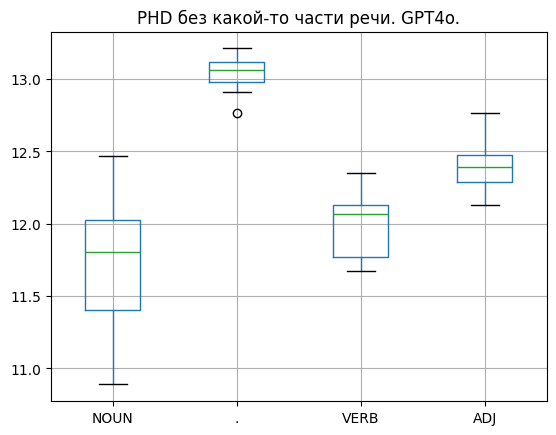

In [79]:
pd.DataFrame(typetoken2phd_4o_without).boxplot()
plt.title("PHD без какой-то части речи. GPT4o.")
plt.show()

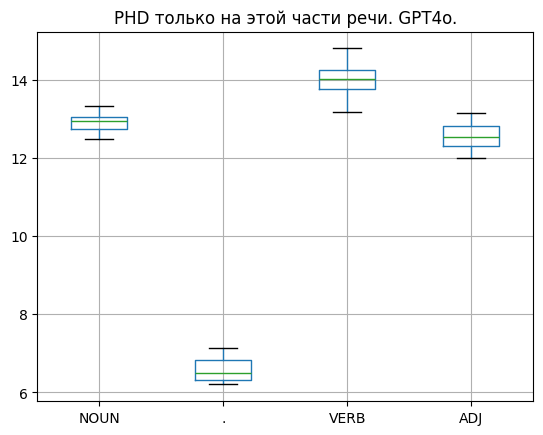

In [80]:
pd.DataFrame(typetoken2phd_4o).boxplot()
plt.title("PHD только на этой части речи. GPT4o.")
plt.show()

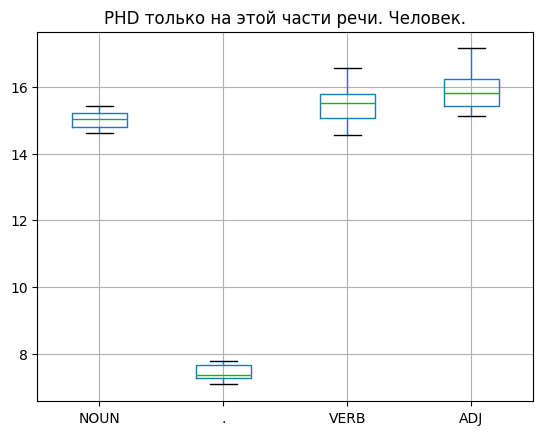

In [81]:
pd.DataFrame(typetoken2phd_human).boxplot()
plt.title("PHD только на этой части речи. Человек.")
plt.show()

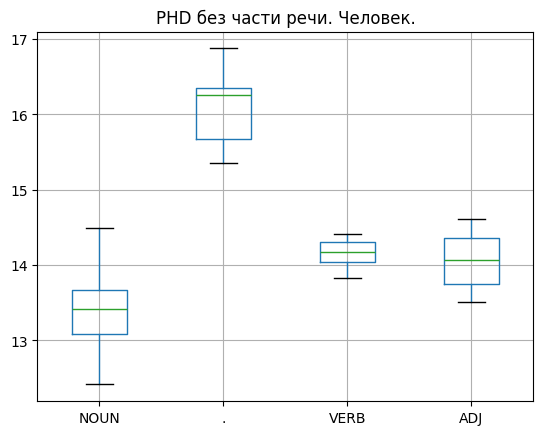

In [83]:
pd.DataFrame(typetoken2phd_human_without).boxplot()
plt.title("PHD без части речи. Человек.")
plt.show()

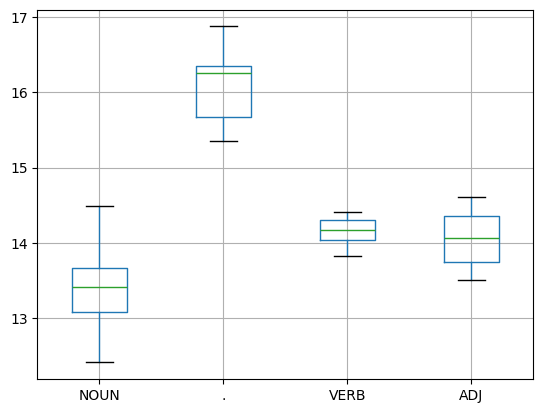

In [76]:
pd.DataFrame(typetoken2phd_human_without).boxplot()
plt.show()

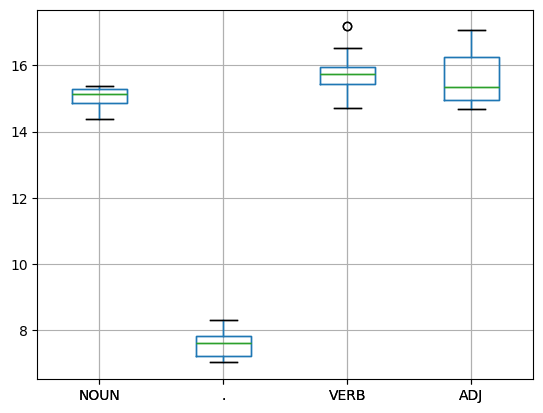

In [50]:
import matplotlib.pyplot as plt


pd.DataFrame(typetoken2phd_human).boxplot()
plt.show()

In [99]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(nrows=2, ncols=2)




# Now, you can access and plot on each individual subplot using the axs array
# Example: Plotting on the top-left subplot (row 0, column 0)

pd.DataFrame(typetoken2phd_4o_without).boxplot(ax=axs[0, 0])
axs[0, 0].set_title("PHD БЕЗ части речи. GPT4o.")


# Example: Plotting on the top-right subplot (row 0, column 1)
pd.DataFrame(typetoken2phd_4o).boxplot(ax=axs[0, 1])
axs[0, 1].set_title("PHD части речи. GPT4o.")


# Example: Plotting on the bottom-left subplot (row 1, column 0)
pd.DataFrame(typetoken2phd_human_without).boxplot(ax=axs[1, 0])
axs[1, 0].set_title('PHD без части речи. Человек.')

# Example: Plotting on the bottom-right subplot (row 1, column 1)
pd.DataFrame(typetoken2phd_human).boxplot(ax=axs[1, 1])
axs[1, 1].set_title('PHD части речи. Человек.')


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.savefig("phd_by_author.png")